# Grid-search model evaluation on test images

This section loads the grid-search Keras model and evaluates it on the test images located at:

- Load the model
- Preprocess images to the model input shape
- Predict and print a classification report and confusion matrix


In [5]:
# Imports and model loading
import os
from pathlib import Path
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from PIL import Image

# Paths - adjust if needed
TEST_DIR = Path(r"D:/R&I_ThermalCameras/TD_IR_EMOTIONS_CROPPED/ByEmotion")
MODEL_PATH = Path(r"D:/R&I_ThermalCameras/thermal_emotion_model_gridsearch.h5")

print("Test dir:", TEST_DIR)
print("Model path:", MODEL_PATH)

# Load model (Keras)
model = load_model(str(MODEL_PATH))
print("Loaded model:", MODEL_PATH.name)

# Inspect expected input shape (Keras format: (None, H, W, C) or similar)
input_shape = model.input_shape
print("Model input_shape:", input_shape)

H, W = 128, 128
try:
    C = int(input_shape[3]) if len(input_shape) >= 4 and input_shape[3] is not None else 3
except Exception:
    C = 3

print(f"Target size (H,W,C): {(H,W,C)}")

# class names derived from folder names (sorted)
class_names = sorted([p.name for p in TEST_DIR.iterdir() if p.is_dir()])
print("Class names (sorted):", class_names)
for cls in class_names:
    print(cls, len(list((TEST_DIR/cls).glob('*'))))


Test dir: D:\R&I_ThermalCameras\TD_IR_EMOTIONS_CROPPED\ByEmotion
Model path: D:\R&I_ThermalCameras\thermal_emotion_model_gridsearch.h5
Loaded model: thermal_emotion_model_gridsearch.h5
Model input_shape: (None, 128, 128, 3)
Target size (H,W,C): (128, 128, 3)
Class names (sorted): ['Happy', 'Natural', 'Surprise']
Happy 110
Natural 332
Surprise 111


In [6]:
# Load images, preprocess and run predictions
import math
from sklearn.metrics import classification_report, confusion_matrix

# helper to load and preprocess an image
from PIL import Image

def load_and_preprocess(image_path, target_h, target_w, channels):
    img = Image.open(image_path)
    if channels == 1:
        img = img.convert('L')
    else:
        img = img.convert('RGB')
    img = img.resize((int(target_w), int(target_h)), Image.BILINEAR)
    arr = np.array(img).astype('float32') / 255.0
    if channels == 1:
        # ensure shape (H,W,1)
        if arr.ndim == 2:
            arr = np.expand_dims(arr, axis=-1)
    return arr

# collect test examples
X_list = []
y_true = []
paths = []
for idx, cls in enumerate(class_names):
    cls_dir = TEST_DIR / cls
    for f in sorted(cls_dir.glob('*')):
        if not f.is_file():
            continue
        try:
            arr = load_and_preprocess(f, H, W, C)
            X_list.append(arr)
            y_true.append(idx)
            paths.append(str(f))
        except Exception as e:
            print('Skipped', f, '->', e)

if len(X_list) == 0:
    raise SystemExit('No test images were loaded. Check TEST_DIR and folder structure.')

X = np.stack(X_list, axis=0)
y_true = np.array(y_true)
print('Loaded images:', X.shape, 'labels:', y_true.shape)

# run predictions
batch_size = 32
preds = model.predict(X, batch_size=batch_size)
print('Predictions shape:', preds.shape)

if preds.ndim == 2 and preds.shape[1] > 1:
    y_pred = preds.argmax(axis=1)
else:
    # likelihood or single logit
    y_pred = (preds.ravel() > 0.5).astype(int)

print('Unique true labels:', np.unique(y_true))
print('Unique predicted labels:', np.unique(y_pred))


Loaded images: (553, 128, 128, 3) labels: (553,)
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predictions shape: (553, 5)
Unique true labels: [0 1 2]
Unique predicted labels: [0 1 2 3 4]
Predictions shape: (553, 5)
Unique true labels: [0 1 2]
Unique predicted labels: [0 1 2 3 4]


Test accuracy: 0.2441 (24%)

Classification report:

              precision    recall  f1-score   support

       Happy     0.1616    0.2909    0.2078       110
     Natural     0.5000    0.2229    0.3083       332
    Surprise     0.2071    0.2613    0.2311       111
     Class_3     0.0000    0.0000    0.0000         0
     Class_4     0.0000    0.0000    0.0000         0

    accuracy                         0.2441       553
   macro avg     0.1738    0.1550    0.1494       553
weighted avg     0.3739    0.2441    0.2728       553



C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:17

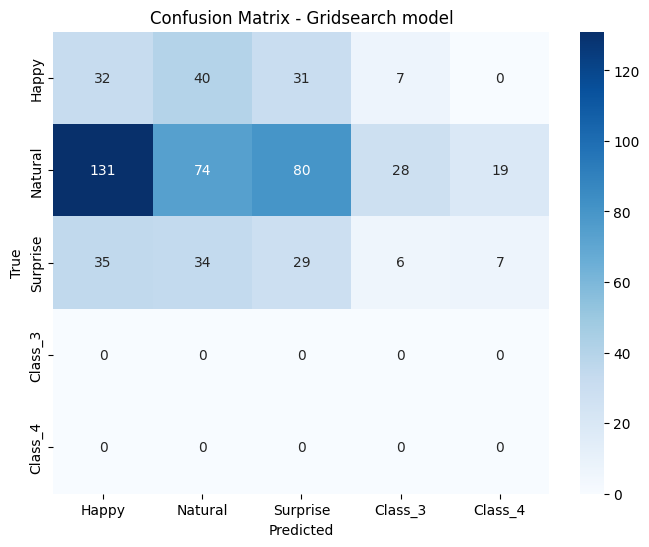

Saved: D:\R&I_ThermalCameras\TD_IR_EMOTIONS_CROPPED\ByEmotion\classification_report_gridsearch.csv
Saved: D:\R&I_ThermalCameras\TD_IR_EMOTIONS_CROPPED\ByEmotion\confusion_matrix_gridsearch.npy

One sample (misclassified):
Path: D:\R&I_ThermalCameras\TD_IR_EMOTIONS_CROPPED\ByEmotion\Happy\101_TD_IR_E_2.jpg
Actual label: 0 -> Happy
Predicted label: 2 -> Surprise


C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:17

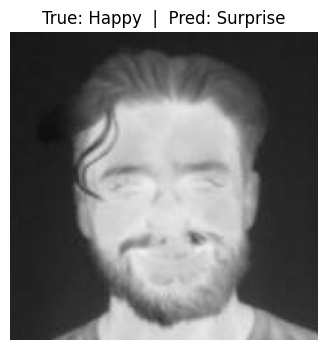

In [7]:
# Classification report, confusion matrix, accuracy and one sample output
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from PIL import Image
import random

# determine labels present in y_true and y_pred (handles missing classes)
labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
# build readable names for labels (use folder names where available)
target_names_full = [class_names[i] if i < len(class_names) else f'Class_{i}' for i in labels]

# compute and print accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Test accuracy: {acc:.4f} ({int(acc * 100)}%)")

# classification report
rep = classification_report(y_true, y_pred, labels=labels, target_names=target_names_full, digits=4)
print('\nClassification report:\n')
print(rep)

# confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names_full, yticklabels=target_names_full, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Gridsearch model')
plt.show()

# save report and confusion matrix to test folder
out_report = TEST_DIR / 'classification_report_gridsearch.csv'
out_cm = TEST_DIR / 'confusion_matrix_gridsearch.npy'

# save classification report as dataframe
rep_dict = classification_report(y_true, y_pred, labels=labels, target_names=target_names_full, output_dict=True)
pd.DataFrame(rep_dict).transpose().to_csv(out_report)
np.save(out_cm, cm)
print('Saved:', out_report)
print('Saved:', out_cm)

# show one sample: prefer a misclassified example if any, else random
mis_idxs = [i for i,(t,p) in enumerate(zip(y_true, y_pred)) if t != p]
if len(mis_idxs) > 0:
    pick = mis_idxs[0]
    note = 'misclassified'
else:
    pick = 0
    note = 'example'

sample_path = paths[pick]
sample_true = y_true[pick]
sample_pred = y_pred[pick]

print(f"\nOne sample ({note}):")
print('Path:', sample_path)
print('Actual label:', sample_true, '->', (class_names[sample_true] if sample_true < len(class_names) else f'Class_{sample_true}'))
print('Predicted label:', sample_pred, '->', (class_names[sample_pred] if sample_pred < len(class_names) else f'Class_{sample_pred}'))

# display image
try:
    img = Image.open(sample_path)
    plt.figure(figsize=(4,4))
    if img.mode != 'RGB' and C != 1:
        img = img.convert('RGB')
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_names[sample_true] if sample_true < len(class_names) else sample_true}  |  Pred: {class_names[sample_pred] if sample_pred < len(class_names) else sample_pred}")
    plt.show()
except Exception as e:
    print('Could not open sample image for display:', e)


Found 200 misclassified images; inspecting 50 samples
Saved inspection CSV to D:\R&I_ThermalCameras\TD_IR_EMOTIONS_CROPPED\ByEmotion\analysis_misclassified\inspection_report.csv
Saved gallery to D:\R&I_ThermalCameras\TD_IR_EMOTIONS_CROPPED\ByEmotion\analysis_misclassified\gallery_50.png


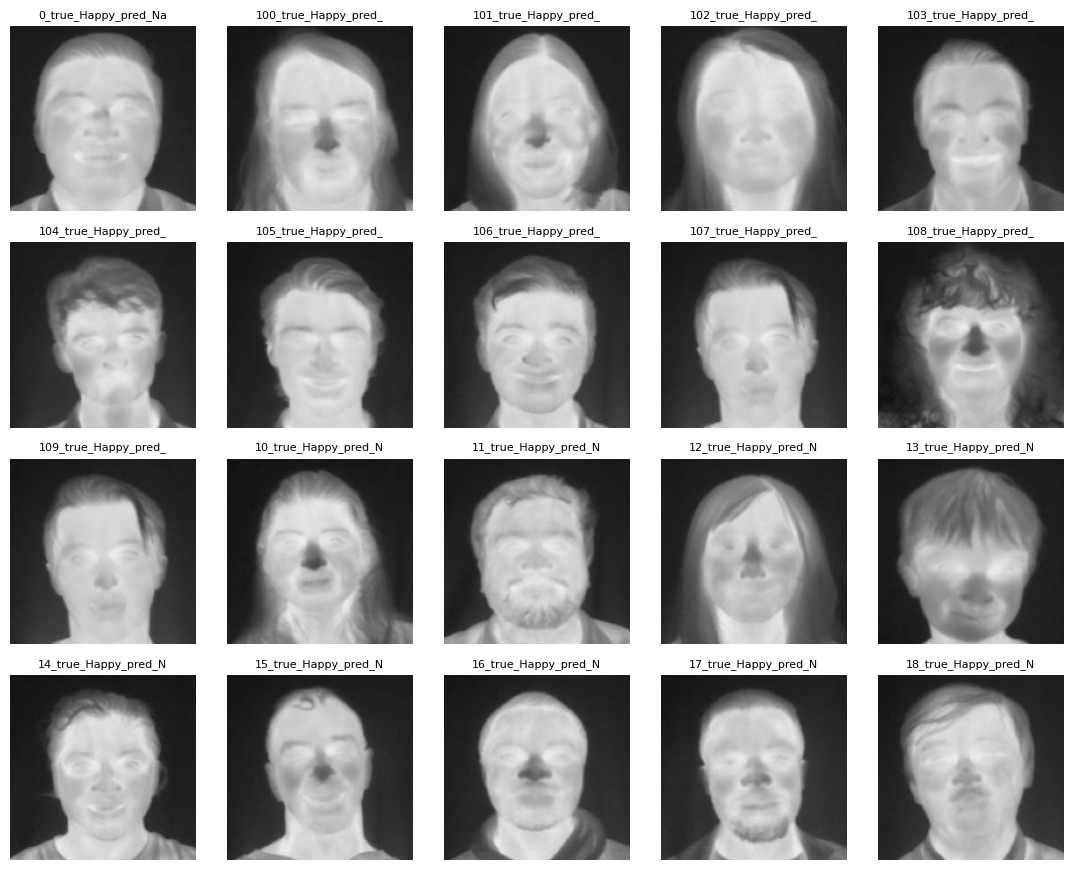


Quick summary:
 - total_inspected: 50
 - num_small: 0
 - num_low_contrast: 0
 - num_many_saturated: 0
 - mode_counts: {'RGB': 50}
 - avg_std: 73.8958780563621
 - avg_mean: 107.84405771382279

Top 10 low-contrast images:


,filename,width,height,std,mean



Done. Review the CSV and gallery in the analysis folder.


In [10]:
# Inspect a sample of misclassified images and compute image-quality metrics
# - Loads up to N images from TEST_DIR/analysis_misclassified
# - Computes size, mode, mean, std, percent near black/white, aspect ratio
# - Flags low-contrast, small, many-saturated pixels
# - Saves a CSV (`inspection_report.csv`) and a gallery image (`gallery_XX.png`)
# - Displays a thumbnail grid of up to 20 images inline for quick visual review

import math
from pathlib import Path
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

analysis_dir = TEST_DIR / 'analysis_misclassified'
if not analysis_dir.exists():
    raise SystemExit(f'Analysis directory not found: {analysis_dir} (run earlier cells first)')

# list images
imgs = sorted([p for p in analysis_dir.iterdir() if p.is_file() and p.suffix.lower() in ['.jpg','.jpeg','.png','.bmp']])
N = min(50, len(imgs))
print(f'Found {len(imgs)} misclassified images; inspecting {N} samples')
imgs = imgs[:N]

rows = []
thumbs = []
for p in imgs:
    try:
        with Image.open(p) as im:
            im_load = im.convert('RGB')
            arr = np.array(im_load)
            h,w = arr.shape[:2]
            mode = im.mode
            mean = float(arr.mean())
            std = float(arr.std())
            pct_black = float((arr <= 10).sum()) / arr.size
            pct_white = float((arr >= 245).sum()) / arr.size
            aspect = float(w)/float(h) if h>0 else None
            small = (w < 100) or (h < 100)
            low_contrast = std < 15.0
            many_saturated = (pct_black + pct_white) > 0.02
            # try to parse filename pattern '..._true_<label>_pred_<label>...'
            fname = p.name
            true_label = None
            pred_label = None
            parts = fname.split('_')
            try:
                ti = parts.index('true')
                true_label = parts[ti+1]
            except ValueError:
                pass
            try:
                pi = parts.index('pred')
                pred_label = parts[pi+1].split('.')[0]
            except ValueError:
                pass

            rows.append({
                'path': str(p),
                'filename': fname,
                'true_label_in_name': true_label,
                'pred_label_in_name': pred_label,
                'width': w,
                'height': h,
                'mode': mode,
                'mean': mean,
                'std': std,
                'pct_black': pct_black,
                'pct_white': pct_white,
                'aspect_ratio': aspect,
                'small': small,
                'low_contrast': low_contrast,
                'many_saturated': many_saturated
            })

            # create a small thumbnail for display
            thumb = ImageOps.fit(im_load, (160,160), Image.BILINEAR)
            thumbs.append((thumb, fname))
    except Exception as e:
        print('Failed to process', p, '->', e)

# save CSV
out_csv = analysis_dir / 'inspection_report.csv'
df = pd.DataFrame(rows)
df.to_csv(out_csv, index=False)
print('Saved inspection CSV to', out_csv)

# Save gallery for up to N images (arrange into a grid)
cols = 5
rows_grid = math.ceil(len(thumbs)/cols)
if len(thumbs) > 0:
    gallery_w = cols * 160
    gallery_h = rows_grid * 160
    gallery = Image.new('RGB', (gallery_w, gallery_h), color=(255,255,255))
    for idx, (t,fname) in enumerate(thumbs):
        r = idx // cols
        c = idx % cols
        gallery.paste(t, (c*160, r*160))
    gallery_path = analysis_dir / f'gallery_{len(thumbs)}.png'
    gallery.save(gallery_path)
    print('Saved gallery to', gallery_path)

    # display first 20 thumbnails inline (or all if <=20)
    display_count = min(20, len(thumbs))
    fig_cols = 5
    fig_rows = math.ceil(display_count/fig_cols)
    plt.figure(figsize=(fig_cols*2.2, fig_rows*2.2))
    for i in range(display_count):
        plt.subplot(fig_rows, fig_cols, i+1)
        plt.imshow(thumbs[i][0])
        plt.title(thumbs[i][1][:20], fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Summarize findings
summary = {
    'total_inspected': len(rows),
    'num_small': int(df['small'].sum()),
    'num_low_contrast': int(df['low_contrast'].sum()),
    'num_many_saturated': int(df['many_saturated'].sum()),
    'mode_counts': df['mode'].value_counts().to_dict(),
    'avg_std': float(df['std'].mean()) if len(df)>0 else None,
    'avg_mean': float(df['mean'].mean()) if len(df)>0 else None
}
print('\nQuick summary:')
for k,v in summary.items():
    print(f' - {k}: {v}')

# show top problematic filenames
if len(df) > 0:
    print('\nTop 10 low-contrast images:')
    display(df[df['low_contrast']].sort_values('std').head(10)[['filename','width','height','std','mean']])

print('\nDone. Review the CSV and gallery in the analysis folder.')


In [11]:
# Quick fine-tune on a small balanced subset (short run)
# - Builds a small balanced dataset from TEST_DIR (cap per-class)
# - Replaces the final classification head and fine-tunes last layers
# - Saves a checkpoint and prints a short evaluation on the validation split

from pathlib import Path
import numpy as np
import pandas as pd
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Parameters (safe, small run)
TARGET_SIZE = (128,128)
BATCH_SIZE = 16
EPOCHS = 3
MAX_PER_CLASS = 120  # cap per class to keep run short
OUT_MODEL = Path(r"D:/R&I_ThermalCameras/thermal_emotion_finetuned_small.h5")

# Check required variables
for v in ['model','TEST_DIR']:
    if v not in globals():
        raise SystemExit(f'Required variable `{v}` not found. Make sure the model and TEST_DIR are loaded.')

# Collect balanced samples (use first N per class)
class_dirs = sorted([p for p in TEST_DIR.iterdir() if p.is_dir()])
file_rows = []
for cls_dir in class_dirs:
    files = sorted([str(p) for p in cls_dir.glob('*') if p.suffix.lower() in ('.jpg','.jpeg','.png')])
    sample = files[:MAX_PER_CLASS]
    for f in sample:
        file_rows.append({'filepath': f, 'class': cls_dir.name})

if len(file_rows) == 0:
    raise SystemExit('No files found for fine-tune. Check TEST_DIR contents.')

df = pd.DataFrame(file_rows)
print('Samples per class (collected):')
print(df['class'].value_counts())

# Shuffle and split train/val
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split = int(len(df) * 0.8)
df_train = df.iloc[:split].copy()
df_val = df.iloc[split:].copy()

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   rotation_range=15,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   zoom_range=0.05)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(df_train, x_col='filepath', y_col='class',
                                              target_size=TARGET_SIZE, class_mode='categorical',
                                              batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(df_val, x_col='filepath', y_col='class',
                                          target_size=TARGET_SIZE, class_mode='categorical',
                                          batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_gen.class_indices)
print('Detected classes:', train_gen.class_indices)

# Build fine-tune model: attach a new Dense head on top of the penultimate layer if possible
try:
    base_output = model.layers[-2].output
except Exception:
    # fallback: use model output tensor and add new head on top of an intermediate layer
    try:
        base_output = model.layers[-1].input
    except Exception:
        raise SystemExit('Could not locate a suitable intermediate output to attach new head. Manual adjustment needed.')

new_logits = Dense(num_classes, activation='softmax', name='ft_logits')(base_output)
ft_model = Model(inputs=model.input, outputs=new_logits)

# Freeze all but the last 4 layers
for layer in ft_model.layers[:-4]:
    layer.trainable = False

ft_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# compute class weights
y_train_labels = df_train['class'].map(train_gen.class_indices).values
classes_unique = np.unique(y_train_labels)
if len(classes_unique) > 0:
    class_weights_arr = compute_class_weight('balanced', classes=classes_unique, y=y_train_labels)
    cw = {int(i): float(class_weights_arr[i]) for i in range(len(class_weights_arr))}
else:
    cw = None
print('Class weights:', cw)

# Fit (short)
history = ft_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, class_weight=cw)

# Save checkpoint
ft_model.save(str(OUT_MODEL))
print('Saved fine-tuned model to', OUT_MODEL)

# Quick evaluation on validation set
val_gen.reset()
preds = ft_model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
from sklearn.metrics import classification_report, confusion_matrix
print('\nValidation classification report:')
print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))
print('\nConfusion matrix:')
print(confusion_matrix(y_true, y_pred))


Samples per class (collected):
class
analysis_misclassified    120
Natural                   120
Surprise                  111
Happy                     110
Name: count, dtype: int64
Found 368 validated image filenames belonging to 4 classes.
Found 93 validated image filenames belonging to 4 classes.
Detected classes: {'Happy': 0, 'Natural': 1, 'Surprise': 2, 'analysis_misclassified': 3}


AttributeError: The layer sequential_98 has never been called and thus has no defined input.

In [12]:
# Quick fine-tune (corrected cell) — short run
# This cell attempts to build the model to create input tensors before attaching a new head.
# If the build step is successful, it will fine-tune the last layers for a few epochs and save a checkpoint.

from pathlib import Path
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Parameters
TARGET_SIZE = (128,128)
BATCH_SIZE = 16
EPOCHS = 3
MAX_PER_CLASS = 120
OUT_MODEL = Path(r"D:/R&I_ThermalCameras/thermal_emotion_finetuned_small_v2.h5")

# Validate environment
for v in ['model','TEST_DIR','H','W','C']:
    if v not in globals():
        raise SystemExit(f'Required variable `{v}` missing. Run previous cells to load model and set H,W,C.')

# Try to build the model's input tensors (helpful for Sequential models that weren't built explicitly)
try:
    model.build((None, int(H), int(W), int(C)))
    print('Model built with input shape', (None, int(H), int(W), int(C)))
except Exception as e:
    print('model.build() may not be necessary or failed:', e)

# Collect small balanced dataset
class_dirs = sorted([p for p in TEST_DIR.iterdir() if p.is_dir()])
file_rows = []
for cls_dir in class_dirs:
    files = sorted([str(p) for p in cls_dir.glob('*') if p.suffix.lower() in ('.jpg','.jpeg','.png')])
    sample = files[:MAX_PER_CLASS]
    for f in sample:
        file_rows.append({'filepath': f, 'class': cls_dir.name})

if not file_rows:
    raise SystemExit('No files found in TEST_DIR')

df = pd.DataFrame(file_rows)
print('Collected sample counts:')
print(df['class'].value_counts())

# split train/val
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split = int(len(df)*0.8)
df_train = df.iloc[:split].copy()
df_val = df.iloc[split:].copy()

# Generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   zoom_range=0.05)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(df_train, x_col='filepath', y_col='class',
                                              target_size=TARGET_SIZE, class_mode='categorical',
                                              batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(df_val, x_col='filepath', y_col='class',
                                          target_size=TARGET_SIZE, class_mode='categorical',
                                          batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_gen.class_indices)
print('Classes:', train_gen.class_indices)

# Attach a new head robustly
# Try to use penultimate output; if not available, use last layer input
try:
    penult = model.layers[-2].output
except Exception:
    penult = None
    try:
        penult = model.layers[-1].input
    except Exception:
        penult = None

if penult is None:
    raise SystemExit('Could not determine penultimate tensor for model; manual adjustment required')

new_logits = Dense(num_classes, activation='softmax', name='ft_logits')(penult)
try:
    ft_model = Model(inputs=model.input, outputs=new_logits)
except Exception as e:
    raise SystemExit(f'Failed to create functional fine-tune model automatically: {e}')

# Freeze early layers
for layer in ft_model.layers[:-4]:
    layer.trainable = False

ft_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Class weights
y_train_labels = df_train['class'].map(train_gen.class_indices).values
class_weights_arr = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
cw = {int(i): float(class_weights_arr[i]) for i in range(len(class_weights_arr))}
print('Class weights:', cw)

# Short training
history = ft_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, class_weight=cw)

# Save
ft_model.save(str(OUT_MODEL))
print('Saved fine-tuned model to', OUT_MODEL)

# Eval
val_gen.reset()
preds = ft_model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
from sklearn.metrics import classification_report, confusion_matrix
print('\nValidation report:')
print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))
print('\nConfusion matrix:')
print(confusion_matrix(y_true, y_pred))


Model built with input shape (None, 128, 128, 3)
Collected sample counts:
class
analysis_misclassified    120
Natural                   120
Surprise                  111
Happy                     110
Name: count, dtype: int64
Found 368 validated image filenames belonging to 4 classes.
Found 93 validated image filenames belonging to 4 classes.
Classes: {'Happy': 0, 'Natural': 1, 'Surprise': 2, 'analysis_misclassified': 3}


SystemExit: Failed to create functional fine-tune model automatically: The layer sequential_98 has never been called and thus has no defined input.

C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\interactiveshell.py:3680: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
# Inspect model architecture and layers (index, name, class, output shape, trainable)
print('Model type:', type(model))
try:
    model.summary()
except Exception as e:
    print('Could not call model.summary():', e)

print('\nLayer index, name, class, output_shape, trainable:')
for i, layer in enumerate(model.layers):
    try:
        out_shape = getattr(layer, 'output_shape', None)
    except Exception:
        out_shape = None
    print(i, layer.name, layer.__class__.__name__, out_shape, getattr(layer, 'trainable', None))


Model type: <class 'keras.src.models.sequential.Sequential'>


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_294 (Conv2D)             │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_294               │ (None, 63, 63, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_295 (Conv2D)             │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_295               │ (None, 30, 30, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_296 (Conv2D)             │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_296               │ (None, 14, 14, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_98 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,287 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


Layer index, name, class, output_shape, trainable:
0 conv2d_294 Conv2D None True
1 max_pooling2d_294 MaxPooling2D None True
2 conv2d_295 Conv2D None True
3 max_pooling2d_295 MaxPooling2D None True
4 conv2d_296 Conv2D None True
5 max_pooling2d_296 MaxPooling2D None True
6 flatten_98 Flatten None True
7 dense_196 Dense None True
8 dropout_98 Dropout None True
9 dense_197 Dense None True


In [14]:
# Fine-tune using penultimate dense layer as feature tensor (repair attempt)
# This cell will:
# - build a small balanced dataset (if not present)
# - create generators
# - attach a new Dense head on top of model.layers[7].output (dense_196)
# - freeze early layers and train last layers for a few epochs

from pathlib import Path
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

print('Model type:', type(model))
# Ensure model built
try:
    model.build((None, int(H), int(W), int(C)))
    print('Model built OK')
except Exception as e:
    print('model.build() warning:', e)

# Collect balanced small dataset (repeat to be robust)
MAX_PER_CLASS = 120
class_dirs = sorted([p for p in TEST_DIR.iterdir() if p.is_dir()])
file_rows = []
for cls_dir in class_dirs:
    files = sorted([str(p) for p in cls_dir.glob('*') if p.suffix.lower() in ('.jpg','.jpeg','.png')])
    sample = files[:MAX_PER_CLASS]
    for f in sample:
        file_rows.append({'filepath': f, 'class': cls_dir.name})

if not file_rows:
    raise SystemExit('No files found in TEST_DIR')

df = pd.DataFrame(file_rows)
print('Collected counts:')
print(df['class'].value_counts())

# split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split = int(len(df)*0.8)
df_train = df.iloc[:split].copy()
df_val = df.iloc[split:].copy()

# Generators
TARGET_SIZE = (int(H), int(W))
BATCH_SIZE = 16
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   zoom_range=0.05)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(df_train, x_col='filepath', y_col='class',
                                              target_size=TARGET_SIZE, class_mode='categorical',
                                              batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(df_val, x_col='filepath', y_col='class',
                                          target_size=TARGET_SIZE, class_mode='categorical',
                                          batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_gen.class_indices)
print('Detected classes:', train_gen.class_indices)

# Choose penultimate layer index explicitly (as observed)
penult_idx = 7  # dense_196 per inspection
if penult_idx < 0 or penult_idx >= len(model.layers):
    raise SystemExit('penult_idx out of range; adjust index')
penult_layer = model.layers[penult_idx]
print('Using penultimate layer:', penult_idx, penult_layer.name, type(penult_layer))

# Get the tensor corresponding to this layer's output
try:
    penult_tensor = penult_layer.output
except Exception as e:
    raise SystemExit('Could not get penultimate tensor output: ' + str(e))

# Attach new head
new_logits = Dense(num_classes, activation='softmax', name='ft_logits')(penult_tensor)
try:
    ft_model = Model(inputs=model.input, outputs=new_logits)
    print('Functional fine-tune model created')
except Exception as e:
    raise SystemExit('Failed to create functional model: ' + str(e))

# Freeze early layers
for layer in ft_model.layers[:-4]:
    layer.trainable = False

ft_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# class weights
y_train_labels = df_train['class'].map(train_gen.class_indices).values
class_weights_arr = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
cw = {int(i): float(class_weights_arr[i]) for i in range(len(class_weights_arr))}
print('Class weights:', cw)

# Train short
EPOCHS = 3
history = ft_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, class_weight=cw)

# Save
OUT_MODEL = Path(r"D:/R&I_ThermalCameras/thermal_emotion_finetuned_repair.h5")
ft_model.save(str(OUT_MODEL))
print('Saved fine-tuned model to', OUT_MODEL)

# Evaluate on val
val_gen.reset()
preds = ft_model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
from sklearn.metrics import classification_report, confusion_matrix
print('\nValidation classification report:')
print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))
print('\nConfusion matrix:')
print(confusion_matrix(y_true, y_pred))


Model type: <class 'keras.src.models.sequential.Sequential'>
Model built OK
Collected counts:
class
analysis_misclassified    120
Natural                   120
Surprise                  111
Happy                     110
Name: count, dtype: int64
Found 368 validated image filenames belonging to 4 classes.
Found 93 validated image filenames belonging to 4 classes.
Detected classes: {'Happy': 0, 'Natural': 1, 'Surprise': 2, 'analysis_misclassified': 3}
Using penultimate layer: 7 dense_196 <class 'keras.src.layers.core.dense.Dense'>


SystemExit: Failed to create functional model: The layer sequential_98 has never been called and thus has no defined input.

C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\interactiveshell.py:3680: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [16]:
# Fine-tune excluding analysis_misclassified and evaluate on full test set (clean run)
# - Uses only emotion folders (filters out any folder with 'analysis' in the name)
# - Builds a functional feature extractor from the existing Sequential model
# - Trains a small head for a few epochs and saves model
# - Evaluates on the full ByEmotion test set (only real emotion folders)

from pathlib import Path
import numpy as np
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import json

# Params
TARGET_SIZE = (int(H), int(W))
BATCH_SIZE = 16
EPOCHS = 4
MAX_PER_CLASS = 200
OUT_MODEL = Path(r"D:/R&I_ThermalCameras/thermal_emotion_finetuned_clean.h5")
TEST_DIR = Path(r"D:/R&I_ThermalCameras/TD_IR_EMOTIONS_CROPPED/ByEmotion")

# Select class directories (exclude analysis or similarly named folders)
class_dirs = sorted([p for p in TEST_DIR.iterdir() if p.is_dir() and 'analysis' not in p.name.lower()])
print('Using class directories:', [p.name for p in class_dirs])

# Collect up to MAX_PER_CLASS samples per real class
file_rows = []
for cls_dir in class_dirs:
    files = sorted([str(p) for p in cls_dir.glob('*') if p.suffix.lower() in ('.jpg','.jpeg','.png')])
    sample = files[:MAX_PER_CLASS]
    for f in sample:
        file_rows.append({'filepath': f, 'class': cls_dir.name})

if not file_rows:
    raise SystemExit('No files found after filtering classes. Check TEST_DIR.')

df = pd.DataFrame(file_rows)
print('Collected samples per class:')
print(df['class'].value_counts())

# train/val split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split = int(len(df) * 0.8)
df_train = df.iloc[:split].copy()
df_val = df.iloc[split:].copy()

# generators
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10,
                                   width_shift_range=0.05, height_shift_range=0.05, zoom_range=0.05)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(df_train, x_col='filepath', y_col='class',
                                              target_size=TARGET_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True)
val_gen = val_datagen.flow_from_dataframe(df_val, x_col='filepath', y_col='class',
                                          target_size=TARGET_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_gen.class_indices)
print('Training classes:', train_gen.class_indices)

# Build feature extractor by applying existing Sequential layers up to penultimate
# Determine penultimate index programmatically: last Dense before final Dense (heuristic)
penult_idx = None
for i, layer in enumerate(model.layers[::-1]):
    if layer.__class__.__name__.lower().startswith('dense'):
        # find index from front
        penult_idx = len(model.layers) - 1 - i
        break
if penult_idx is None or penult_idx <= 0:
    # fallback to fixed index observed earlier
    penult_idx = 7
print('Using penultimate layer index:', penult_idx, 'name:', model.layers[penult_idx].name)

# Create new Input and reapply layers
x_in = Input(shape=(int(H), int(W), int(C)))
_x = x_in
for layer in model.layers[:penult_idx+1]:
    _x = layer(_x)

# Attach new head
new_logits = Dense(num_classes, activation='softmax', name='clean_ft_logits')(_x)
ft_model = Model(inputs=x_in, outputs=new_logits)
print('Constructed fine-tune model:', ft_model.input_shape, '->', ft_model.output_shape)

# Freeze early layers
for layer in ft_model.layers[:-4]:
    layer.trainable = False

ft_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# compute class weights
y_train_labels = df_train['class'].map(train_gen.class_indices).values
class_weights_arr = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
cw = {int(i): float(class_weights_arr[i]) for i in range(len(class_weights_arr))}
print('Class weights:', cw)

# Train
history = ft_model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, class_weight=cw)

# Save model
ft_model.save(str(OUT_MODEL))
print('Saved fine-tuned cleaned model to', OUT_MODEL)

# Evaluate on full test set (only real classes)
# Build full test dataframe
test_rows = []
for cls_dir in class_dirs:
    for p in sorted(cls_dir.glob('*')):
        if p.suffix.lower() in ('.jpg','.jpeg','.png'):
            test_rows.append({'filepath': str(p), 'class': cls_dir.name})

df_test = pd.DataFrame(test_rows)
print('Test set size:', len(df_test))

# Use a generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_dataframe(df_test, x_col='filepath', y_col='class',
                                             target_size=TARGET_SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False)

# predict and report
preds = ft_model.predict(test_gen)
y_pred = preds.argmax(axis=1)
y_true = test_gen.classes
class_index_to_name = {v:k for k,v in test_gen.class_indices.items()}

report = classification_report(y_true, y_pred, target_names=[class_index_to_name[i] for i in range(len(class_index_to_name))])
print('\nFull-test classification report (clean model):\n')
print(report)

cm = confusion_matrix(y_true, y_pred)
print('\nConfusion matrix:\n', cm)

# save artifacts
out_dir = TEST_DIR
(out_dir / 'classification_report_finetuned_clean.txt').write_text(report)
np.save(out_dir / 'confusion_matrix_finetuned_clean.npy', cm)
print('Saved report and confusion matrix to', out_dir)

# Save mapping (train class indices)
with open(out_dir / 'finetune_class_indices.json', 'w') as f:
    json.dump(train_gen.class_indices, f, indent=2)
print('Saved class_indices to', out_dir / 'finetune_class_indices.json')


Using class directories: ['Happy', 'Natural', 'Surprise']
Collected samples per class:
class
Natural     200
Surprise    111
Happy       110
Name: count, dtype: int64
Found 336 validated image filenames belonging to 3 classes.
Found 85 validated image filenames belonging to 3 classes.
Training classes: {'Happy': 0, 'Natural': 1, 'Surprise': 2}
Using penultimate layer index: 9 name: dense_197
Constructed fine-tune model: (None, 128, 128, 3) -> (None, 3)
Class weights: {0: 1.2727272727272727, 1: 0.7044025157232704, 2: 1.2584269662921348}
Epoch 1/4


C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.3571 - loss: 1.1151 - val_accuracy: 0.4118 - val_loss: 1.0604
Epoch 2/4
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4018 - loss: 1.0902 - val_accuracy: 0.4235 - val_loss: 1.0573
Epoch 3/4
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3750 - loss: 1.1050 - val_accuracy: 0.4353 - val_loss: 1.0554
Epoch 4/4
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4107 - loss: 1.0849 - val_accuracy: 0.4706 - val_loss: 1.0547


Saved fine-tuned cleaned model to D:\R&I_ThermalCameras\thermal_emotion_finetuned_clean.h5
Test set size: 553
Found 553 validated image filenames belonging to 3 classes.


C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Full-test classification report (clean model):

              precision    recall  f1-score   support

       Happy       0.26      0.78      0.39       110
     Natural       0.79      0.48      0.60       332
    Surprise       0.28      0.05      0.08       111

    accuracy                           0.45       553
   macro avg       0.44      0.44      0.35       553
weighted avg       0.58      0.45      0.45       553


Confusion matrix:
 [[ 86  21   3]
 [163 159  10]
 [ 84  22   5]]
Saved report and confusion matrix to D:\R&I_ThermalCameras\TD_IR_EMOTIONS_CROPPED\ByEmotion
Saved class_indices to D:\R&I_ThermalCameras\TD_IR_EMOTIONS_CROPPED\ByEmotion\finetune_class_indices.json
